# Understanding URBS

A simple notebook to help understand what URBS (and RORBS) is doing under the hood. 

## URBS Storage - Basic Model
### Storage in URBS
The URBS Basic Model (and RORBS) gives the storage of a single catchment reservoir as a function of outflow Q.  

$k$ is a coeffiecient that describes the relationship between $Q$ and $S$ (storage-discharge). It is parameterized by a bunch of things 
to do with the characteristics of the catchment. I recommend reading the manual for more details.

$
k = \frac{\alpha \cdot f \cdot L \cdot n (1+F)^2}{\sqrt{S_c}(1+U)^2}
$

$
S_{URBS} =  kQ^m
$

In [6]:
def storage(
        alpha,  # Storage lag parameter
        f,      # Reach length factor
        L,      # Reach length
        n,      # Manning's roughness
        F,      # Forested fraction
        S_c,    # Channel slope
        U,      # Urbanisation fraction
        m,      # Catchment non-linearity
        Q       # Discharge
    ):
    """
    Calculate the catchment and channel storage of a single reservoir.
    """

    return (
        (alpha * f * L * n * (1 + F) ** 2) /
        (S_c ** 0.5 * (1 + U) ** 2) * 
        Q ** m
    )

In [7]:
# Test the function                                       Description               Response
assert storage(0.7, 1, 1, 1, 0, 1, 0, 1, 1) == 0.7      # storage lag parameter     (Linear)
assert storage(1, 0.7, 1, 1, 0, 1, 0, 1, 1) == 0.7      # reach length factor       (Linear)
assert storage(1, 1, 10, 1, 0, 1, 0, 1, 1) == 10        # Reach length              (Linear)
assert storage(1, 1, 1, 0.05, 0, 1, 0, 1, 1) == 0.05    # Manning's roughness       (Linear)
assert storage(1, 1, 1, 1, 1, 1, 0, 1, 1) == 4          # Forested fraction         (Quadratic)    
assert storage(1, 1, 1, 1, 0, 4, 0, 1, 1) == 0.5        # Channel slope             (Square root)
assert storage(1, 1, 1, 1, 0, 1, 1, 1, 1) == 0.25       # Urbanisation fraction     (Inverse quadratic)
assert storage(1, 1, 1, 1, 0, 1, 0, 3, 2) == 8          # Catchment non-linearity   (some exponent)
assert storage(1, 1, 1, 1, 0, 1, 0, 2, 2) == 4          # Discharge                 (some exponent)

To get a feel for the behaviour of this relationship with different values of parameters let's plot some values.

First, let's look at the catchment's non-linearity $m$. The storage in the catchment does not have to scale linearly with flow. It can be seen that with lower values of the exponent $m$, it requires a much larger flow to increase the storage of the system.

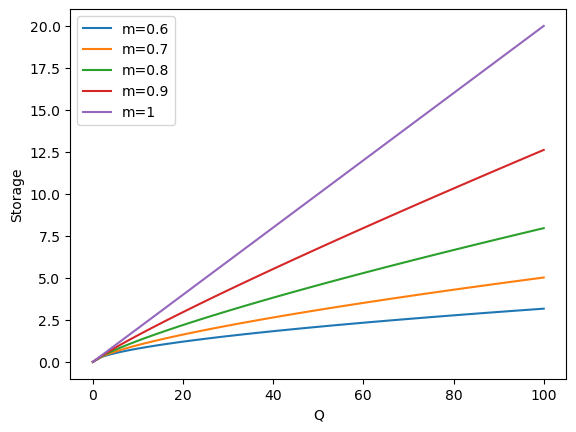

In [111]:
import matplotlib.pyplot as plt
import numpy as np

q = np.linspace(0, 100, 51)
for m in [0.6, 0.7, 0.8, 0.9, 1]:
    plt.plot(q, storage(0.2, 1, 1, 1, 0, 1, 0, m, q), label=f'm={m}')
plt.xlabel('Q')
plt.ylabel('Storage')
plt.legend()
plt.show()

Now let's look at the behaviour when changing the storage lag parameter $\alpha$. $\alpha$ just scales the storage by a factor of $\alpha$. That is, smaller values of $\alpha$ squish the curve while keeping the same shape.

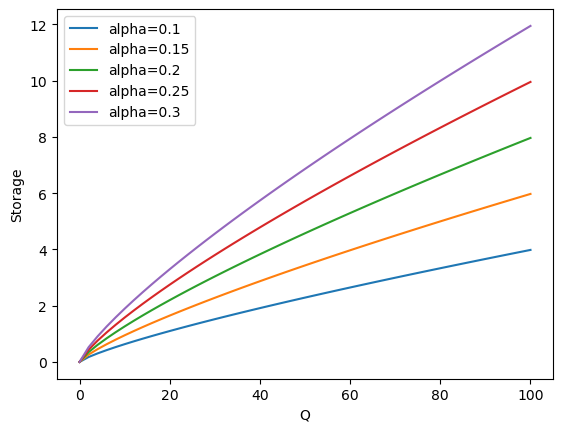

In [9]:
q = np.linspace(0, 100, 51)
for a in [0.1, 0.15, 0.2, 0.25, 0.3]:
    plt.plot(q, storage(a, 1, 1, 1, 0, 1, 0, 0.8, q), label=f'alpha={a}')
plt.xlabel('Q')
plt.ylabel('Storage')
plt.legend()
plt.show()

Other parameters can be checked in the same way. 

## How to get Q?

We have the relationship between storage and discharge, but we don't know Q at this stage, as it changes with S, which changes with Q, which changes with S...  

We need to introduce the storage equation which is derived from the continuity of mass. Essential it says, _"In fluid dynamics, the continuity equation states that the rate at which mass enters a system is equal to the rate at which mass leaves the system plus the accumulation of mass within the system"_

What comes in is $i$, what goes out is $q$, what accumulates is $S$

### Storage Equation  
The change of what is in the system is the difference between what comes in and what goes out. 

$
\frac{dS}{dt} = i - q
$

Or in terms of averages; we will use this in the algorithm to find Q.

$
\Delta S = \frac{\Delta t}{2} ( \left( i_0 + i_1 \right) - \left( q_0 + q_1 \right) )
$

And so storage at time $t$ is then,

$
S_{t} = S_{t-1} + \Delta S
$

In [10]:
def storage_delta(
        i_0,      # Inflow at time 0
        i_1,      # Inflow at time 1
        q_0,      # Outflow at time 0
        q_1,      # Outflow at time 1
        t_delta   # Time delta

    ):
    """
    Calculate the change in storage for a given inflow and outflow. 
    """
    return (
        (t_delta / 2) * ((i_0 + i_1) - (q_0 + q_1))
    )

In [11]:
# Test
assert storage_delta(0, 2, 0, 1, 1) == 0.5
assert storage_delta(5, 3, 0, 1, 1) == 3.5

### The algorithm to solve Q at each timestep.

To know what $Q$ is we have to solve the equation.

$
S_{URBS(t)} = S_t \quad \forall \quad  t \in T
$

In words, the storage in the catchment that URBS tells us there is has to be equal to the storage that the continuity of mass tells us there is. So we have to find some value of the outflow $Q$ that satisfies this equality. We will do this numerically by brute force, there are however better algorithms to do this.

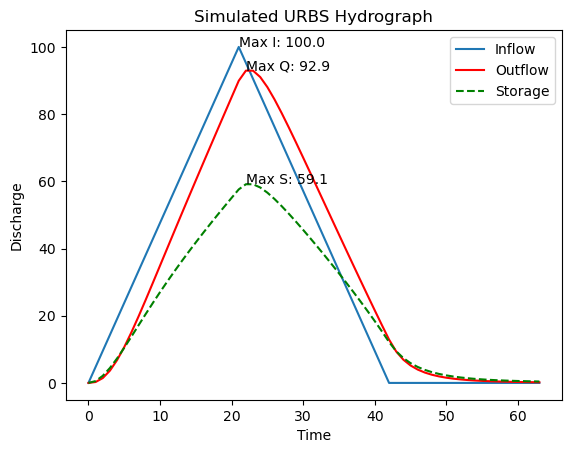

In [145]:
# ----------------- Parameters --------------------------
# Time
dt = 0.25       # Four time steps per unit hydrograph

# Hydrograph
scale = 100
hydrograph = np.array([0, 0.2, 0.4, 0.6, 0.8, 1, 0.8, 0.6, 0.4, 0.2, 0, 0, 0, 0, 0, 0])     # Unit hydrograph
hydrograph = scale * hydrograph                                                             # Scale the unit hydrograph

# Break the hydrograph into smaller time steps based on dt, making the calculations more precise.
x = np.linspace(0, len(hydrograph)-1, len(hydrograph))
x_new = np.linspace(0, len(hydrograph)-1, int(len(hydrograph)/dt)) 
hydrograph_interpolated = np.interp(x_new, x, hydrograph)
i = hydrograph_interpolated

# URBS Parameters (Change these and see what happens)
m = 0.8
alpha = 0.3
L = 7
n = 0.075
Sc = 0.01

## ---------- Algorithm -------------------------
# set some initial values for time 0.
Q = [0]     # Q is the outflow at each time step
S = [0]     # S is the storage at each time step

# For each time step t, defined in the hydrograph
for t in range(1, len(i)):
    q = Q[t-1]          # Set the outflow to the previous outflow, trial outflow. 
    d = -1              # Initialise the difference

    # While the equality has not converged.
    # Loop through values of q, until the equality is satisfied.
    while np.abs(d) > 0.01:
        q -= 0.001 * np.sign(d)                             # Decend a small amount in the direction of the difference.
        s = storage(alpha, 1, L, n, 0, Sc, 0, m, q)         # Calculate the storage.
        ds = storage_delta(i[t-1], i[t], Q[t-1], q, dt)     # Calculate the change in storage.
        d = s - (S[t-1] + ds)                               # Calculate the difference between storages for this q.
    
    # Once we have found a value of q that satisfies the difference, append the values to the record.
    S.append(s)
    Q.append(q)

## ---------- Plot the results -----------------------
plt.plot(i, label='Inflow')
plt.plot(Q, color='r', label='Outflow')
plt.plot(S, color='g', label='Storage', linestyle='--')
max_i = np.max(i)
max_S = np.max(S)
max_Q = np.max(Q)
plt.annotate(f'Max S: {round(max_S,1)}', xy=(np.argmax(S), max_S))
plt.annotate(f'Max I: {round(max_i,1)}', xy=(np.argmax(i), max_i))
plt.annotate(f'Max Q: {round(max_Q,1)}', xy=(np.argmax(Q), max_Q))
plt.title('Simulated URBS Hydrograph')
plt.xlabel('Time')
plt.ylabel('Discharge')
plt.legend()
plt.show()

We can check that the algorithm is doing the right thing by taking the integral of $i - q$ over the time domain $T$. This should equal the storage we determined above. There will be an error in the true value, as the equality is not solved exactly. 

$
S = \int_T (i - q)
$

By plotting the storage cure against the integral, it is obvious that the storage is being calculated correctly. 

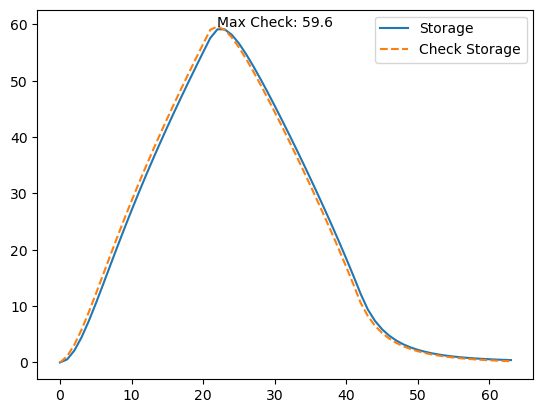

In [139]:
check_s = (np.cumsum(i) - np.cumsum(Q)) * dt    #discrete integral of inflow - outflow scaled by dt

# Plot the storage and the check storage.
plt.plot(S, label='Storage')
plt.plot(check_s, label='Check Storage', linestyle='--')
plt.annotate(f'Max Check: {round(np.max(check_s),1)}', xy=(np.argmax(S), np.max(check_s)))
plt.legend()
plt.show()

## Summary 
This is a basic example of the principles of how URBS (and RORB) calculate the outflow from catchments. A single reservoir with a unit hydrograph was used, with the catchment and reach storage being lumped together. A production URBS model will have multiple reservoirs (basins) with complex temporal patterns, routing to other downstream reservoirs, creating much more complicated hydrographs. By varying the parameters of the model, we can get a feel for the behaviour of the algorithm, reducing storage in a catchment leads to an increase in runoff. This makes intuitive sense, as the continuity of mass must hold, the less a system can store, the more mass it must release. 

This is provided for education purposes, therefore,

THIS INFORMATION IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THIS INFORMATION.
